## ECE276C Assignment 3: Policy Gradients

by Shivani Bhakta

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
# import pybullet
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical 
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import time

### Setup Device

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


#### Function to get plots for all parts of this assignment

In [3]:
def get_plot(avg_return, title): 
    %matplotlib inline
    plt.figure()
    plt.plot(avg_return)
    plt.xlabel('# iterations')
    plt.ylabel('Average Returns')
    plt.title(title)
    plt.show()

### Question 2 - 2 Link Arm



In [4]:
class PolicyNet2(nn.Module):

    def __init__(self, env):

        super(PolicyNet2, self).__init__()
        
        self.num_state = 8
        self.num_action = env.action_space.shape[0] 


        self.l1 = nn.Linear(self.num_state, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64,64)
        self.l4 = nn.Linear(64, self.num_action)

    def forward(self, x):

        network = nn.Sequential(
            self.l1,
            nn.Tanh(),
            self.l2,
            nn.Tanh(),
            self.l3,
            nn.Tanh(),
            self.l4,
            nn.Tanh())

        return network(torch.FloatTensor(x).to(device))

In [5]:
def get_action(model, state, flag = False):
    '''
    This function gets the next action given the model and the current state. 
    '''
    
    action_probs = model.forward(state)
    covariance_matrix = torch.abs(torch.diag(torch.FloatTensor([0.2, 0.2]))) + 1e-3
    m = MultivariateNormal(action_probs, covariance_matrix)
    
    action = m.sample()
    log_prob = m.log_prob(action)
    
    if flag: 
        return action_probs.tolist(), log_prob
    
    return action.tolist(), log_prob

In [6]:
def get_discounted_return(gamma,traj_reward):
    '''
    Get discounted return for current step.
    '''
    re = []
    for t in range(0, len(traj_reward)):
        result = []
        for t_prime in range(t, len(traj_reward)):
            result.append(gamma ** (t_prime - t) * traj_reward[t_prime])  
        re.append(sum(result))
    return re

In [7]:
def reinforce(env, model, optimizer, batch_size = 500, \
              epochs = 200, gamma = 0.9, activate_b = False): 
  
    """
    Train a policy using policy gradient method.
    
    Inputs:
    - env: gym environment object
    - model: PolicyNet 
    - optimizer: An Optimizer object we will use to train the model
    - batch_size: batch size 
    - epochs: A Python integer giving the number of episodes to train for
    - gamma: discount factor for Monte carlo estimate
    - activate_b: flag to activate the baseline or not (subtrating b)  
    
    Returns: average reward for each episode and prints model accuracies during training.
    """
   
    # List to store average reward per episode/trajectory in each iteration. 
    avg_reward = []
    avg_step = [] # store step over episode
    
    for e in range(epochs):
        # this is a loop for each trajectory of the pole.
        
        # trackers for each trajectory. 
        traj_reward = []
        traj_logs_prob = []
        traj_counter = 0
        
        # trackers for each batch 
        batch_traj_counter = 0
        batch_loss = 0
        batch_reward = []
        batch_logs_prob = []
        batch_discounted_return = []
        
        state = env.reset()
        done = False

        
        for step in range(batch_size):
            #get next action and state 
            action, log_prob = get_action(model, state)
            state_next, reward, done, info = env.step(action)
            
            #store state/action info
            traj_reward.append(reward)
            traj_logs_prob.append(log_prob) 
            
            #check if done
            if done or (step == batch_size -1):
                # calculate G(t)
                # G(t) = sum gamma**t * r(t) 
                discounted_return = get_discounted_return(gamma,traj_reward)

                batch_logs_prob.extend(traj_logs_prob)
                batch_discounted_return.extend(discounted_return) 
                
                batch_reward.append(np.sum(traj_reward))
                batch_traj_counter += 1
                                              
                # reset state
                traj_counter = 0
                traj_reward = []
                traj_logs_prob = []
                
                state = env.reset()
                                              
            else: 
                state = state_next
                
                
        if activate_b:
            b = np.mean(batch_discounted_return) # such that mean of the modified returns is 0
            batch_discounted_return -=  b
   
        for step in range(len(batch_logs_prob)):
            batch_loss += batch_logs_prob[step] * batch_discounted_return[step]
        
        
        avg_reward.append(np.mean(batch_reward))
        loss = - batch_loss / batch_traj_counter
        avg_step.append(batch_size / batch_traj_counter)
        
        print('Epoch %d, loss = %.2f, avg_reward: %.2f' % (e, loss.item(), np.mean(batch_reward) ))
        
    
        # break if policy has converged
        if batch_traj_counter >= batch_size / 25:
            print('Policy has converged.')
            break
            
        # update policy parameters 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return avg_reward

### Train the policy 

In [8]:
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=False)
state = env.reset()

model = PolicyNet2(env).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
average_reward_list= reinforce(env, model,optimizer, batch_size=800, epochs=350,
                                               gamma=0.9, activate_b=True)

Epoch 0, loss = -3.86, avg_reward: -30.55
Epoch 1, loss = -6.76, avg_reward: -28.93
Epoch 2, loss = -4.38, avg_reward: -27.15
Epoch 3, loss = -4.90, avg_reward: -28.73
Epoch 4, loss = -6.23, avg_reward: -24.05
Epoch 5, loss = -2.65, avg_reward: -33.17
Epoch 6, loss = -4.78, avg_reward: -28.19
Epoch 7, loss = -6.75, avg_reward: -26.86
Epoch 8, loss = -2.93, avg_reward: -28.63
Epoch 9, loss = -1.28, avg_reward: -23.72
Epoch 10, loss = -4.80, avg_reward: -27.81
Epoch 11, loss = 2.57, avg_reward: -23.69
Epoch 12, loss = -4.44, avg_reward: -28.47
Epoch 13, loss = -3.53, avg_reward: -27.85
Epoch 14, loss = -4.68, avg_reward: -27.95
Epoch 15, loss = -4.79, avg_reward: -25.22
Epoch 16, loss = -6.83, avg_reward: -29.19
Epoch 17, loss = -2.53, avg_reward: -27.53
Epoch 18, loss = -4.18, avg_reward: -31.27
Epoch 19, loss = -4.95, avg_reward: -34.44
Epoch 20, loss = -4.35, avg_reward: -32.90
Epoch 21, loss = -2.84, avg_reward: -27.56
Epoch 22, loss = -5.03, avg_reward: -31.11
Epoch 23, loss = -5.37

Epoch 189, loss = -5.32, avg_reward: -26.36
Epoch 190, loss = -1.27, avg_reward: -16.70
Epoch 191, loss = -3.68, avg_reward: -18.42
Epoch 192, loss = -5.65, avg_reward: -27.84
Epoch 193, loss = -7.36, avg_reward: -30.97
Epoch 194, loss = -9.83, avg_reward: -24.44
Epoch 195, loss = -5.55, avg_reward: -26.01
Epoch 196, loss = -4.27, avg_reward: -25.72
Epoch 197, loss = -6.99, avg_reward: -26.11
Epoch 198, loss = -8.39, avg_reward: -25.20
Epoch 199, loss = -10.33, avg_reward: -26.89
Epoch 200, loss = -4.13, avg_reward: -25.61
Epoch 201, loss = -2.74, avg_reward: -25.33
Epoch 202, loss = -4.90, avg_reward: -26.78
Epoch 203, loss = -8.05, avg_reward: -20.53
Epoch 204, loss = -4.26, avg_reward: -22.43
Epoch 205, loss = -5.64, avg_reward: -26.89
Epoch 206, loss = -5.91, avg_reward: -23.87
Epoch 207, loss = -3.60, avg_reward: -21.26
Epoch 208, loss = -4.97, avg_reward: -24.15
Epoch 209, loss = -7.42, avg_reward: -26.09
Epoch 210, loss = -1.94, avg_reward: -26.35
Epoch 211, loss = -4.07, avg_re

### Plot the Average Return

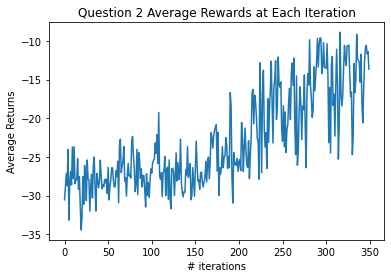

In [9]:
get_plot(average_reward_list, 'Question 2 Average Rewards at Each Iteration')

### Store the model in pickle for using later. 

In [10]:
import pickle
with open('Q2_policy.pkl', 'wb') as pickle_file:
    pickle.dump(model, pickle_file)

### Test Policy on the environment

In [14]:
import pickle
with open('Q2_policy.pkl', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=True)
env.render()
state = env.reset()
done = False
step = 0
time.sleep(6)

while not done:
    action, log_prob = get_action(model, state,flag = True)
    state_next, reward, done, info = env.step(action)
    step = step + 1 
    state = state_next
    time.sleep(0.1)
    
print("Environement completed in {} steps.".format(step))

Environement completed in 42 steps.


For this question I used learning rate $\alpha = 0.01$ and discounted factor $\gamma = 0.9 $. I trained policy for 350 iterations and with batch size of 800. The policy was able to reach the goal for random initial positions.  